In [288]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import seaborn as sns

import random
from collections import deque

plt.style.use('ggplot')

import sys 
sys.path.append('..')


In [289]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2017-01-01']
df_webster = df[df.Cluster == 'WEBSTER']

pred_webster = pd.read_csv('../predictions/best_sweep_tgcn_cpnll_dynamic_2/predictions_TGCN_WEBSTER_trim-shape-30_2.csv', index_col=0)
pred_webster = pred_webster.iloc[:2831]
pred_webster = pred_webster.reset_index(drop=False)

In [290]:

def add_time_columns(df_in, date_name = 'Start Date'):
    df_out = df_in.copy()
    df_out['DayOfWeek'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).dayofweek)
    df_out['Hour'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).hour)
    df_out['Minute'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).minute)
    df_out['HourMinute'] = df_out['Hour'].astype(str) + ':' + df_out['Minute'].astype(str)

    return df_out


df_webster = add_time_columns(df_webster)
pred_webster = add_time_columns(pred_webster, date_name='Date')

In [291]:
## Extract arrival rates from predictions
pred_webster['ArrivalRate'] = pred_webster['WEBSTER_1_pred'].diff(periods=1)
pred_webster = pred_webster.fillna(0)
pred_webster.loc[(pred_webster['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

## Convert service time to hour 
df_webster['Total Duration (hour)'] = df_webster['Total Duration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='WEBSTER_1_pred'>

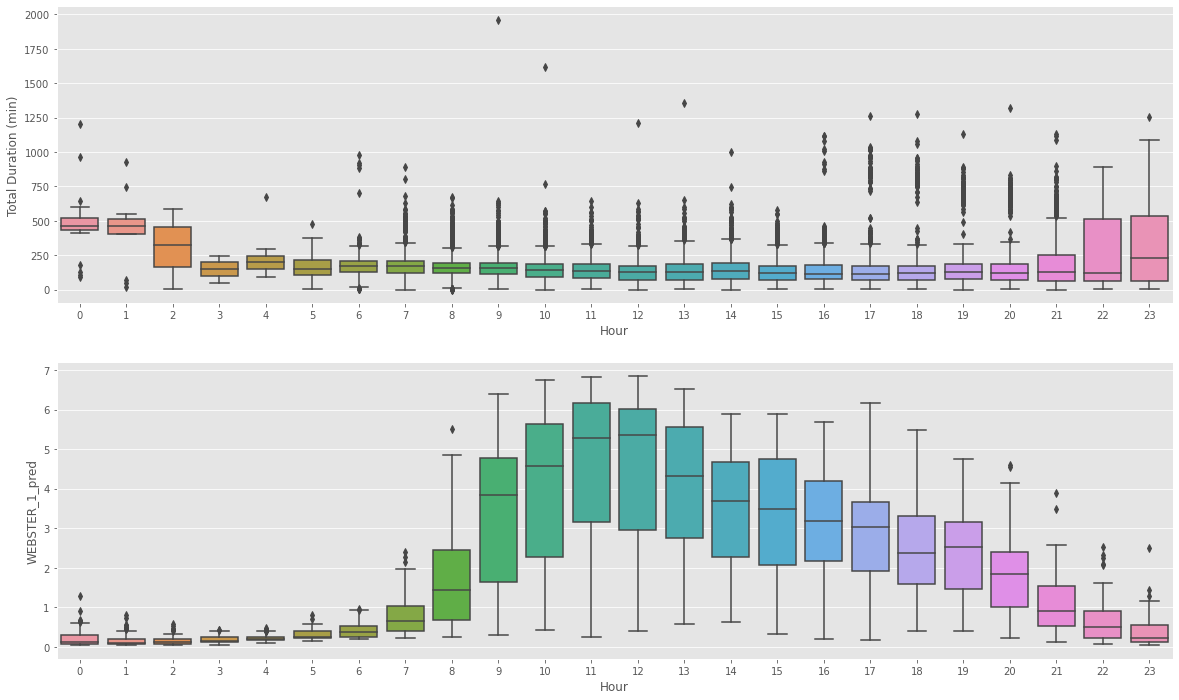

In [292]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=df_webster, x="Hour", y="Total Duration (min)", ax = axes[0])
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[1])

In [293]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

cluster_name = 'WEBSTER'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = pred_webster[(pred_webster['DayOfWeek'] == day_of_week) & (pred_webster['Hour'] == hour)]
    bins = range(0, int(time_specific_df[cluster_name + '_1_pred' ].max()) + 2)
    axs.hist(time_specific_df[cluster_name + '_1_pred'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Predidctions on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.plot_histogram_hour(hour, day_of_week)>

In [294]:
webster_hourly_pluginTime = df_webster.groupby('Hour').mean()
webster_hourly_pluginTime = webster_hourly_pluginTime.reset_index(drop=False)[['Hour', 'Total Duration (min)', 'Total Duration (hour)']]
webster_hourly_prediction = pred_webster.groupby('Hour').mean()
webster_hourly_prediction = webster_hourly_prediction.reset_index(drop=False)[['Hour', 'WEBSTER_1_pred', 'ArrivalRate']]

#### Apply to queue

#### Queue estimating length with our predictions and waiting times as mean service time

In [298]:
webster_hourly_pluginTime['Total Duration (hour)'] = webster_hourly_pluginTime['Total Duration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='Total Duration (hour)'>

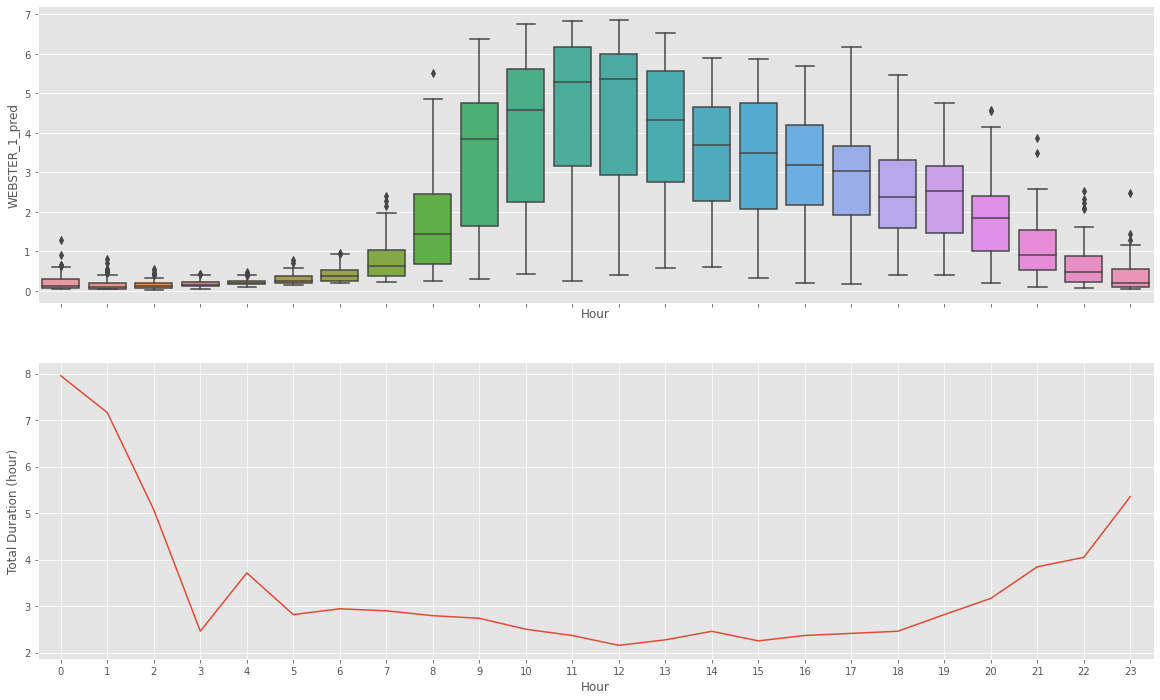

In [299]:
fig, axes = plt.subplots(2, figsize=(20,12), sharex=True)
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[0])
sns.lineplot(data = webster_hourly_pluginTime, x = 'Hour', y = 'Total Duration (hour)', ax = axes[1])

In [300]:
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

In [301]:
pred_webster = pd.merge(
    pred_webster,
    webster_hourly_pluginTime.reset_index(),
    how="inner",
    on = 'Hour')

#pred_webster['AvgWaitingTime'] * pred_webster['AvgWaitingTime'] 
pred_webster['WaitingTime'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['QueueLength']!= 0), 'WaitingTime'] = (pred_webster['QueueLength']*pred_webster['Total Duration (min)'] )

In [302]:
pred_webster

,Date,WEBSTER_1,WEBSTER_1_pred,WEBSTER_1_true,DayOfWeek,Hour,Minute,HourMinute,ArrivalRate,QueueLength,index,Total Duration (min),Total Duration (hour),WaitingTime
0,2019-05-09 00:30:00,0.0,0.107653,0.0,3,0,30,0:30,0.000000,0.0,0,477.142949,7.952382,0.0
1,2019-05-10 00:00:00,0.0,0.182486,0.0,4,0,0,0:0,0.047283,0.0,0,477.142949,7.952382,0.0
2,2019-05-10 00:30:00,0.0,0.250601,0.0,4,0,30,0:30,0.068115,0.0,0,477.142949,7.952382,0.0
3,2019-05-11 00:00:00,1.0,0.638542,1.0,5,0,0,0:0,0.000000,0.0,0,477.142949,7.952382,0.0
4,2019-05-11 00:30:00,1.0,0.589917,1.0,5,0,30,0:30,0.000000,0.0,0,477.142949,7.952382,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2019-06-27 23:30:00,0.0,0.137344,0.0,3,23,30,23:30,0.000000,0.0,23,321.356897,5.355948,0.0
2491,2019-06-28 23:00:00,0.0,0.175962,0.0,4,23,0,23:0,0.000000,0.0,23,321.356897,5.355948,0.0
2492,2019-06-28 23:30:00,0.0,0.131796,0.0,4,23,30,23:30,0.000000,0.0,23,321.356897,5.355948,0.0
2493,2019-06-29 23:00:00,2.0,0.929511,2.0,5,23,0,23:0,0.000000,0.0,23,321.356897,5.355948,0.0


<AxesSubplot:xlabel='Hour', ylabel='WaitingTime'>

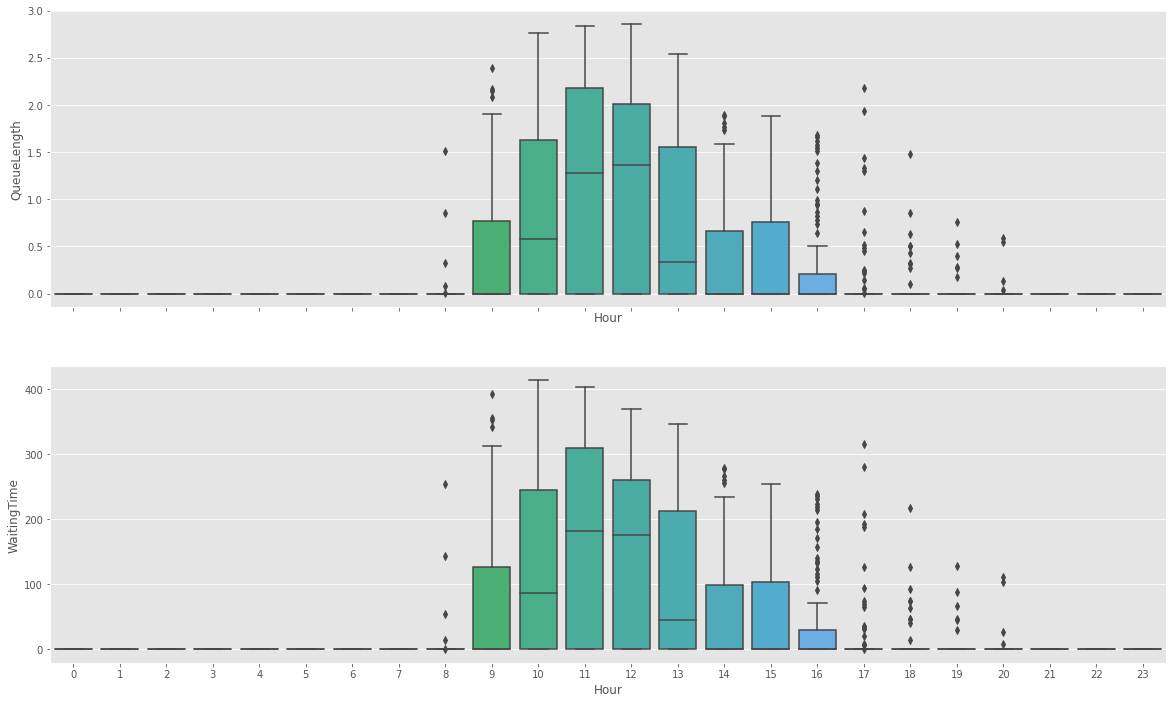

In [303]:
fig, axes = plt.subplots(2, figsize=(20,12), sharex=True)
sns.boxplot(data=pred_webster, x="Hour", y="QueueLength", ax = axes[0])
sns.boxplot(data=pred_webster, x = 'Hour', y = 'WaitingTime', ax = axes[1])

##### Below is an attempt to use queuing theory (poisson arrival, exponential service times)

In [420]:
def mmc_queue_time(lambd, mu, c, time_horizon, seed=None):
    random.seed(seed)  # Set seed for reproducibility

    ## sample arrival times

    # interarrival_times = np.random.poisson(lambd, num_customers)
    arrivals = np.random.poisson(lambd, time_horizon)

    ## sample service times
    service_times = np.random.exponential(1/mu, time_horizon)

    #print(service_times)
    #arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        for k in range(len(queue)):
            if (queue[k] < i):
                queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

def mmc_queue_customers(lambd, mu, c, num_customers, seed=None):
    random.seed(seed)  # Set seed for reproducibility

    ## sample arrival times

    interarrival_times = np.random.exponential(lambd, num_customers)

    ## sample service times
    service_times = np.random.exponential(1/mu, num_customers)

    #print(service_times)
    arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(num_customers)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(num_customers):
        arrival_time = arrival_times[i]
        service_time = service_times[i]

        queue_length.append(len(queue))

        # Check if a server is available
        if len(queue) < c:
           if arrival_time > departure_times[i-1]:
               departure_time = arrival_time + service_time
           else:
               departure_time = departure_times[i-1] + service_time

           departure_times[i] = departure_time
           queue.append(departure_time)
           queue.sort(reverse=True)
        
        elif (len(queue) == c):
            rejected_customers += 1 
        else:
            if arrival_time > departure_time:
                departure_time = arrival_time + service_time
            else:
                departure_time += service_time
            departure_times[i] = departure_time
            queue.append(departure_time)


    return completed_customers, queue_length, rejected_customers
        

Rejected  3 customers due to insuffient plugs in from 13 h and 60 minutes ahead


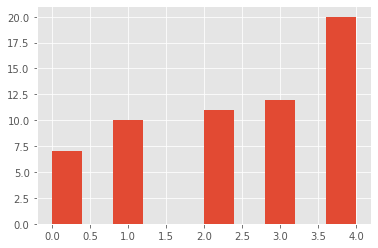

In [427]:
# Example usage
hour_index = 13
lambd =  webster_hourly_prediction.iloc[hour_index]['ArrivalRate']  # arrival time np.random.choice(webster_hourly_pluginTime, 1)[0]
mu =  1 / (webster_hourly_pluginTime.iloc[hour_index]['Total Duration (min)']) # service time  np.random.choice(webster_hourly_pluginTime, 1)[0]  
c = 4  # Number of servers
sim_time = 60 # Number of minutes to simulate

completed_customers, queue_length, rejects = mmc_queue_time(lambd, mu, c, sim_time)
print('Rejected % i customers due to insuffient plugs in from %i h and %i minutes ahead' % (rejects, hour_index, sim_time) )


plt.hist(queue_length)
plt.show()

In [419]:
rejects

6

In [391]:
(webster_hourly_pluginTime.iloc[13]['Total Duration (min)'])

136.55424335378322

In [394]:
completed_customers

[(0, 44.62427840840516),
 (4, 122.03612814333115),
 (6, 10.406428025636854),
 (8, 41.3501187689374),
 (24, 151.77181701868187),
 (29, 121.21811870986548),
 (40, 344.37762157390426),
 (53, 153.34383294281804),
 (55, 78.69236311292184),
 (56, 121.72627930579706)]

In [ ]:
 
'''
Performance Measure
'''
waitList = [startList[i] - arrivalList[i] for i in range(len(startList))]

# [1] plot waiting time 
# [2] plot service time 
bins = np.linspace(0, max(serviceList), 11)

plt.hist(waitList, bins ,facecolor='red', alpha=0.5,label='Waiting Time (Counts)')
arr=plt.hist(waitList, bins, facecolor='red', alpha=0.5)
for i in range(10):
    plt.text(arr[1][i], arr[0][i]+100, str(int(arr[0][i])),color='red')

plt.hist(serviceList, bins, facecolor='green', alpha=0.5,label='Service Time (Counts')
arr=plt.hist(serviceList, bins, facecolor='green', alpha=0.5)
for i in range(10):
    plt.text(arr[1][i], arr[0][i]+100, str(int(arr[0][i])),color='green')

plt.xlabel('Service Time')
plt.ylabel('Counts')
plt.title('Counts of Waiting & Service Time for {} Patients in {} Minutes'.format(len(waitList), args.simT))
plt.axis([min(serviceList), max(serviceList),0,len(serviceList)])
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

avgWait = sum(waitList)/len(waitList)
avgService = sum(serviceList)/len(serviceList)
avgTime = avgWait + avgService
avgCustomer_inSys = avgTime * args.arrR

rho = args.arrR / (args.k * args.serR)
'''
Verify the True/Expected Waiting Time
'''
p1 = 0 
for n in range(args.k):
    p1 += (args.k*rho)**n / math.factorial(n)
p2 = (args.k*rho)**args.k / (math.factorial(args.k)*(1-rho))
p0 = 1 / (p1 + p2)
expectWait = ((args.arrR/args.serR)**args.k * args.serR / (math.factorial(args.k-1)*(args.k*args.serR - args.arrR)**2))*p0
expectTime = expectWait + 1/args.serR
expectCustomer_inSys = expectTime * args.arrR

# expWait_v1 = ((args.arrR/args.serR)**args.k / (math.factorial(args.k)*(args.k*args.serR)*(1-args.arrR/(args.k*args.serR))**2))*p0

print(round(avgWait,5),'[average wait]')
print(round(expectWait,5),'[expect wait]')
print(round(avgCustomer_inSys, 3),'[average customer in system]')
print(round(expectCustomer_inSys, 3),'[expect customer in system]')